In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import numpy as np
from torch.utils.data import Dataset, DataLoader
import glob
import wandb
import os
import torch.optim as optimizers
import dfs_code
from torch_geometric.data import InMemoryDataset, Data
import pickle
import torch
import torch.nn as nn
import tqdm
import copy
import pandas as pd
import torch.nn.functional as F
import sys
import yaml
import functools
from ml_collections import ConfigDict
sys.path = ['../../src'] + sys.path
from dfs_transformer import DFSCodeSeq2SeqFC, Deepchem2TorchGeometric, Trainer, to_cuda, Enzymes
from graphein.protein.resi_atoms import RESI_THREE_TO_1, AMINO_ACIDS

2021-11-09 16:13:18.410959: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/cuda/extras/CUPTI/lib64/:/opt/intel/lib:/opt/intel/mkl/lib/intel64:/opt/intel:/opt/ibm/ILOG/CPLEX_Studio1210/cplex/bin/x86-64_linux:/opt/ibm/ILOG/CPLEX_Studio1210/cplex/python/3.7/x86-64_linux:/opt/intel/clck_latest/lib:/opt/intel/daal/lib:/opt/intel/intelpython3/lib:/opt/intel/ipp/lib:/opt/intel/itac_2019/lib:/opt/intel/itac_latest/lib:/opt/intel/mkl/lib:/opt/intel/mkl_/lib:/opt/intel/mpirt/lib:/opt/intel/tbb/lib:/opt/intel/clck/2019.0/lib:/opt/intel/compilers_and_libraries_2019/linux/lib:/opt/intel/compilers_and_libraries/linux/lib:/opt/intel/itac/2019.0.018/lib:/opt/intel/itac_2019/intel64/lib:/opt/intel/itac_latest/intel64/lib:/opt/intel/parallel_studio_xe_2019.0.045/clck_2019/lib:/opt/intel/parallel_studio_xe_2019.0.045/itac_2019/l

To use the Graphein submodule graphein.protein.features.sequence.embeddings, you need to install biovec.

To do so, use the following command:

    pip install biovec
To use the Graphein submodule graphein.protein.visualisation, you need to install pytorch3d.

pytorch3d cannot be installed via pip
To use the Graphein submodule graphein.protein.meshes, you need to install pytorch3d.

pytorch3d cannot be installed via pip


# download pretrained model

In [3]:
run = wandb.init(mode="online", 
                 project="pubchem", 
                 entity="dfstransformer", 
                 job_type="inference")

model_at = run.use_artifact("bertloops0.3-10M-nofeats" + ":latest")
model_at = run.use_artifact("rnd2min-10M-nofeats" + ":latest")

model_dir = model_at.download()
run.finish()
features = None #"chemprop"
n_samples = 10
fingerprint = 'min-mean-max-std'
load_flag = True

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: chrisxx (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
2021-11-09 16:13:21.129612: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/cuda/extras/CUPTI/lib64/:/opt/intel/lib:/opt/intel/mkl/lib/intel64:/opt/intel:/opt/ibm/ILOG/CPLEX_Studio1210/cplex/bin/x86-64_linux:/opt/ibm/ILOG/CPLEX_Studio1210/cplex/python/3.7/x86-64_linux:/opt/intel/clck_latest/lib:/opt/intel/daal/lib:/opt/intel/intelpython3/lib:/opt/intel/ipp/lib:/opt/intel/itac_2019/lib:/opt/intel/itac_latest/lib:/opt/intel/mkl/lib:/opt/intel/mkl_/lib:/opt/intel/mpirt

wandb: Downloading large artifact rnd2min-10M-nofeats:latest, 191.23MB. 3 files... Done. 0:0:0


In [4]:
with open(model_dir+"/config.yaml") as file:
    config = ConfigDict(yaml.load(file, Loader=yaml.FullLoader))

In [5]:
device = torch.device('cuda:%d'%config.training.gpu_id if torch.cuda.is_available()  else 'cpu')

In [6]:
m = config.model

In [7]:
model = DFSCodeSeq2SeqFC(**m)
if load_flag:
    model.load_state_dict(torch.load(model_dir+'/checkpoint.pt', map_location=device))

In [8]:
model.to(device)

DFSCodeSeq2SeqFC(
  (encoder): DFSCodeEncoder(
    (emb_dfs): PositionalEncoding(
      (dropout): Dropout(p=0, inplace=False)
    )
    (emb_seq): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (emb_atom): Linear(in_features=118, out_features=120, bias=True)
    (emb_bond): Linear(in_features=5, out_features=120, bias=True)
    (mixer): Linear(in_features=600, out_features=600, bias=True)
    (enc): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=600, out_features=600, bias=True)
          )
          (linear1): Linear(in_features=600, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=600, bias=True)
          (norm1): LayerNorm((600,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((600,), eps=1e-05, e

In [9]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print("number of trainable parameters %d"%params)

number of trainable parameters 24696429


# load dataset

In [10]:
trainset = pd.read_csv("../../datasets/mymoleculenet/bbbp/0/train.csv")
train_X, train_y = trainset["smiles"].to_numpy(), trainset["target"].to_numpy()
traindata = Deepchem2TorchGeometric(train_X, train_y, loaddir="../../results/mymoleculenet_plus_features/bbbp/1/", features=features)

In [11]:
import networkx as nx

In [12]:
def nmatch(n1, n2):
    return n1==n2

def ematch(e1, e2):
    return e1==e2

def edit_distance(g1, g2):
    return nx.graph_edit_distance(g1, g2, node_match=nmatch, edge_match=ematch)


# exact edit distance is too expensive, we use approximate edit distance instead
def edit_distance_approx(g1, g2, nsteps=1):
    iterator = nx.optimize_graph_edit_distance(g1, g2, node_match=nmatch, edge_match=ematch)
    for i in range(nsteps):
        try:
            res = next(iterator)
        except:
            break 
    return res

In [13]:
G=nx.Graph()
G.add_node(1, id=1)
G.add_node(2, id=5)
G.add_node(3, id=3)
G.add_edge(1, 2, type='a')
G.add_edge(2, 3, type='b')


G2=nx.Graph()
G2.add_node(1, id=1)
G2.add_node(2, id=2)
G2.add_node(3, id=3)
G2.add_edge(1, 2, type='c')
G2.add_edge(2, 3, type='b')

In [14]:
edit_distance(G,G2)

2.0

In [15]:
def collate_graph(dlist):
    nx_batch = []
    smiles = []
    
    for d in dlist:
        smiles += d.smiles
        graph = nx.Graph()
        for idx, atomic_number in enumerate(d.z.numpy()):
            graph.add_node(idx, atomic_number=atomic_number)
        for edge, edge_type in zip(d.edge_index.numpy().T, np.argmax(d.edge_attr.numpy(), axis=1)):
            graph.add_edge(edge[0], edge[1], bond_type=edge_type)
        nx_batch += [graph]
            
        
    return smiles, nx_batch

In [16]:
def collate_fn(dlist, n_samples=n_samples):
    node_batch = [] 
    edge_batch = []
    y_batch = []
    code_batch = []
    smiles = []
    
    for d in dlist:
        smiles += d.smiles
        for _ in range(n_samples):
            edge_features = d.edge_features.clone()

            code, index = dfs_code.rnd_dfs_code_from_torch_geometric(d, d.z.numpy().tolist(), 
                                                                     np.argmax(d.edge_attr.numpy(), axis=1).tolist())

            code = torch.tensor(code, dtype=torch.long)
            index = torch.tensor(index, dtype=torch.long)
            code_batch += [code]
            node_batch += [d.node_features.clone()]
            edge_batch += [edge_features]
            y_batch += [d.y.clone()]
            
    y = torch.cat(y_batch).unsqueeze(1)
    return smiles, code_batch, node_batch, edge_batch, y

In [17]:
trainloaderg = DataLoader(traindata, batch_size=1, shuffle=False, pin_memory=False, 
                         collate_fn=collate_graph)
trainloader = DataLoader(traindata, batch_size=1, shuffle=False, pin_memory=False, 
                         collate_fn=collate_fn)

In [18]:
graphs = {''.join(d[0]): d[-1] for d in trainloaderg}

In [19]:
graphs = {key: value[0] for key, value in graphs.items()}

In [48]:
#'CCN(CC)CCNC(=O)c1cc(Cl)cc(Cl)c1OC'

In [30]:
reference = graphs['CCN(CC)CC(=O)OCC(=O)C1(O)CCC2C3CCC4=CC(=O)C=CC4(C)C3C(O)CC21C']

In [33]:
from rdkit import Chem
m1 = Chem.MolFromSmiles('CCN(CC)CC(=O)OCC(=O)C1(O)CCC2C3CCC4=CC(=O)C=CC4(C)C3C(O)CC21C')

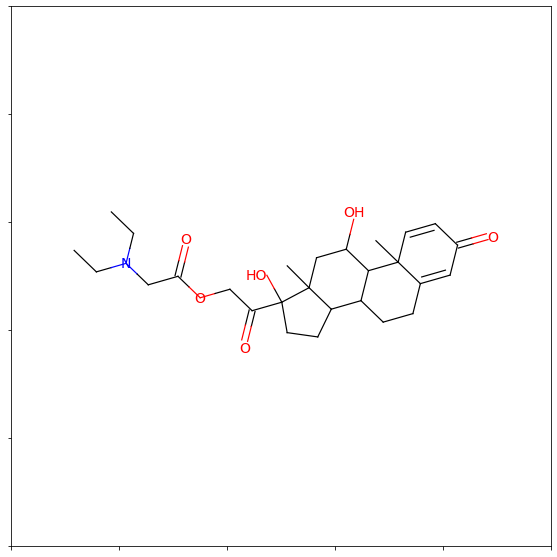

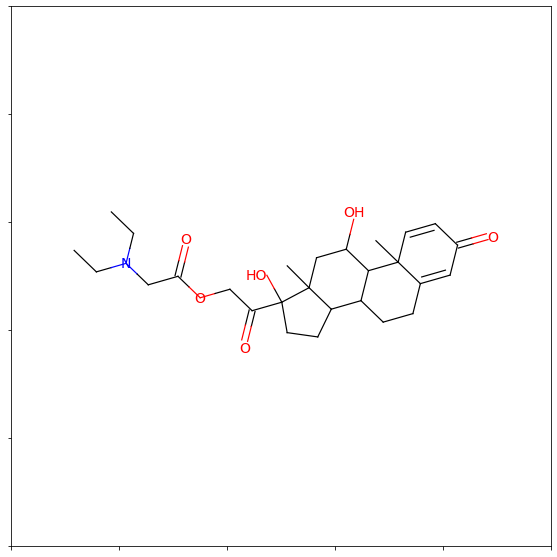

In [34]:
Chem.Draw.MolToMPL(m1)

In [36]:
edit_distances = {}
for smiles, graph in tqdm.tqdm(graphs.items()):
    edit_distances[smiles] = edit_distance_approx(reference, graph, 1)  

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1567/1567 [00:22<00:00, 70.11it/s]


In [37]:
from matplotlib import pyplot as plt

In [38]:
edit_distances['CCN(CC)CCNC(=O)c1cc(Br)c(N)cc1OC']

57.0

In [40]:
np.unique(list(edit_distances.values()))

array([  0.,   1.,  22.,  25.,  26.,  29.,  31.,  32.,  39.,  40.,  41.,
        42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,
        53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,
        64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,
        75.,  76.,  77.,  78.,  83.,  84.,  86.,  87.,  88.,  89.,  91.,
        92.,  93.,  94.,  96.,  98.,  99., 101., 103., 104., 106., 110.,
       112., 114., 116., 144., 148., 166., 199., 257.])

(array([  2.,   0.,   7.,   6., 199., 789., 512.,  21.,  13.,   9.,   4.,
          0.,   0.,   2.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   1.]),
 array([  0.        ,  10.70833333,  21.41666667,  32.125     ,
         42.83333333,  53.54166667,  64.25      ,  74.95833333,
         85.66666667,  96.375     , 107.08333333, 117.79166667,
        128.5       , 139.20833333, 149.91666667, 160.625     ,
        171.33333333, 182.04166667, 192.75      , 203.45833333,
        214.16666667, 224.875     , 235.58333333, 246.29166667,
        257.        ]),
 <BarContainer object of 24 artists>)

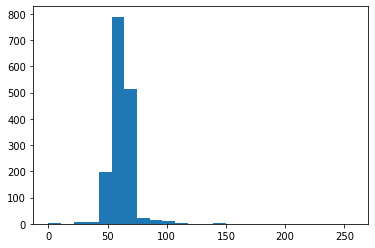

In [41]:
plt.hist(list(edit_distances.values()), bins='rice')

In [42]:
encodings = {}
encodings2 = {}
iterator = iter(trainloader)
for d in tqdm.tqdm(trainloader):
    d = next(iterator)
    smiles = ''.join(d[0])
    d = d[1:]
    d = [to_cuda(dd, device) for dd in d]
    encodings[smiles] = model.encode(*d[:-1], fingerprint).detach().cpu().numpy()
    dfs1, dfs2, atm1, atm2, bnd = model(*d[:-1])
    enc2 = torch.cat((dfs1.mean(dim=0), dfs2.mean(dim=0), atm1.mean(dim=0), atm2.mean(dim=0), bnd.mean(dim=0)), dim=1)
    encodings2[smiles] = enc2.detach().cpu().numpy()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1631/1631 [00:33<00:00, 48.47it/s]


In [44]:
distances = {}

In [45]:
ref_enc = encodings['CCN(CC)CC(=O)OCC(=O)C1(O)CCC2C3CCC4=CC(=O)C=CC4(C)C3C(O)CC21C']
for smiles, enc in tqdm.tqdm(encodings.items()):
    dists = np.linalg.norm(ref_enc - enc, axis=1)
    distances[smiles] = np.mean(dists)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1567/1567 [00:00<00:00, 28348.69it/s]


In [46]:
edit_dists = edit_distances.values()
transf_dists = distances.values() 

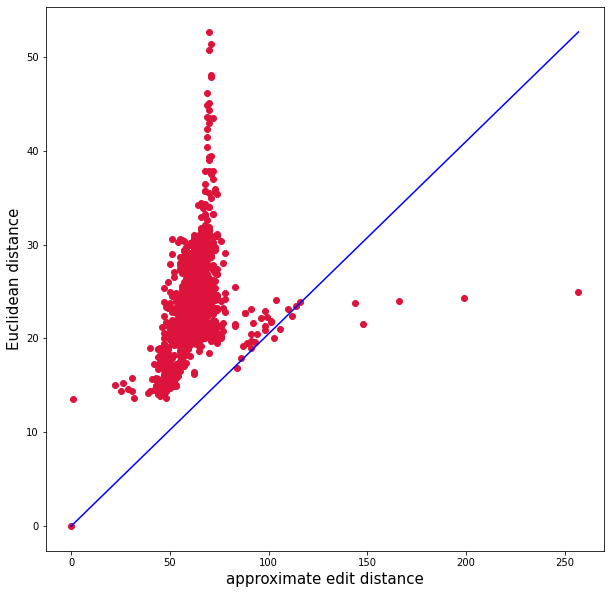

In [47]:
plt.figure(figsize=(10,10))
plt.scatter(edit_dists, transf_dists, c='crimson')

plt.plot([0, max(edit_dists)], [0, max(transf_dists)], 'b-')
plt.xlabel('approximate edit distance', fontsize=15)
plt.ylabel('Euclidean distance', fontsize=15)
plt.show()